In [1]:
import numpy as np
np.set_printoptions(linewidth = 200, precision = 4, suppress = True)

In [2]:
data = np.loadtxt('../NC-Data.csv', delimiter=',', dtype=str)
data = data[1:].astype(float)
k = 7
data

array([[ 1.    , -0.0461,  0.2312, ...,  0.2704,  0.4664,  0.3672],
       [-0.0461,  1.    , -0.0671, ..., -0.0515, -0.0944, -0.0349],
       [ 0.2312, -0.0671,  1.    , ...,  0.147 ,  0.2608,  0.6313],
       ...,
       [ 0.2704, -0.0515,  0.147 , ...,  1.    ,  0.2066,  0.1538],
       [ 0.4664, -0.0944,  0.2608, ...,  0.2066,  1.    ,  0.3486],
       [ 0.3672, -0.0349,  0.6313, ...,  0.1538,  0.3486,  1.    ]])

In [3]:
nodes = np.loadtxt('../NC-K7-Trace-Nodes.csv', delimiter=',', dtype=str)
nodes = nodes[1:].astype(float)
bounds = np.loadtxt('../NC-K7-Trace-Bounds.csv', delimiter=',', dtype=str)
bounds = bounds[1:].astype(float)

In [4]:
# One lower bound impl, and two upper bound impls
i = 3
selection = np.where((nodes == 1).sum(axis=0) == i)[0][0]
bounds[:, selection]

array([4.1355, 5.8707, 7.    ])

In [5]:
raw_data = np.linalg.cholesky(data).T
np.allclose(raw_data.T @ raw_data, data)

True

In [6]:
U = np.linalg.svd(raw_data[:, nodes[:, selection] == 1])[0][:, 0:1]
rank_one_vector = raw_data.T @ U
residual_data = raw_data - U @ (U.T @ raw_data)

In [7]:
np.linalg.matrix_rank(raw_data), np.linalg.matrix_rank(residual_data)

(101, 100)

In [8]:
# Brute-Force Upper Bound. Exponential time complexity.
import itertools
import scipy.special
selected_data = np.where(nodes[:, selection] == 1)[0]
unselected_data = np.where(nodes[:, selection] == -1)[0]
brute_force_data = np.zeros(
    [
        int(scipy.special.binom(len(unselected_data), k - i)),
        k, k,
    ],
    np.float32)
brute_force_data[:, 0:i, 0:i] = data[selected_data, :][:, selected_data]
brute_force_inds = np.asarray(
    list(itertools.combinations(unselected_data, k - i)),
    np.int32)
brute_force_data[:, i:, 0:i] = data[brute_force_inds][:, :, selected_data]
brute_force_data[:, 0:i, i:] = np.transpose(
    brute_force_data[:, i:, 0:i],
    axes=[0, 2, 1])
for index in range(k - i, k):
    brute_force_data[:, index, i:] = (
        data[brute_force_inds[:, index - i:index - i + 1],
             brute_force_inds]
    )
brute_force_data.shape, brute_force_inds.shape

((1502501, 7, 7), (1502501, 4))

In [9]:
np.allclose(
    brute_force_data[42][i:, i:],
    data[:, brute_force_inds[42, :]][brute_force_inds[42, :], :])

False

In [10]:
brute_force_data[42]

array([[ 1.    ,  0.1267,  0.1259, -0.3008, -0.2359, -0.7944, -0.4545],
       [ 0.1267,  1.    ,  0.9886, -0.0098,  0.168 , -0.3048,  0.1556],
       [ 0.1259,  0.9886,  1.    , -0.0247,  0.1813, -0.2793,  0.123 ],
       [-0.3008, -0.0098, -0.0247,  0.    ,  0.    ,  0.    ,  0.    ],
       [-0.2359,  0.168 ,  0.1813, -0.0461,  1.    , -0.0671,  0.4161],
       [-0.7944, -0.3048, -0.2793,  0.2312, -0.0671,  1.    , -0.0467],
       [-0.4545,  0.1556,  0.123 ,  0.1816,  0.4161, -0.0467,  1.    ]], dtype=float32)

In [11]:
brute_force_inds[42, :]

array([ 0,  1,  2, 61], dtype=int32)

In [12]:
brute_force_eigs = np.linalg.eigvalsh(brute_force_data)
opt_inds_loc = np.argmax(brute_force_eigs.max(axis=1))
opt_inds = brute_force_inds[opt_inds_loc, :]
opt_total_inds = np.r_[selected_data, opt_inds]
selected_data, opt_inds, brute_force_eigs[opt_inds_loc, :].max()

(array([ 3, 83, 85]), array([79, 80, 81, 84], dtype=int32), 5.5118036)

In [13]:
# Gersh upper bound on the opt_inds eigvals.
np.abs(data[:, opt_total_inds][opt_total_inds, :]).sum(axis=1).max()

5.804850445790672

In [14]:
# Rank-one greedy lower bound. This out-performed the
# Yuan stochastic approach!
(rank_one_vector[opt_total_inds] ** 2).sum()

5.267480676016405

In [15]:
# Ipsen upper bound on the opt_inds eigvals.
((rank_one_vector[opt_total_inds] ** 2).sum()
    + np.linalg.norm(
        (residual_data[:, opt_total_inds].T @ residual_data[:, opt_total_inds]
        @ rank_one_vector[opt_total_inds]))
        / np.linalg.norm(rank_one_vector[opt_total_inds]))

5.807602843343168

In [16]:
np.c_[np.tile(selected_data[None, :], [len(brute_force_inds), 1]), brute_force_inds].shape

(1502501, 7)

In [17]:
# Ipsen upper bound (brute force).
brute_force_ipsen = (
    (rank_one_vector[selected_data] ** 2).sum()
    + (rank_one_vector[brute_force_inds] ** 2).sum(axis=1))
brute_force_total_inds = np.c_[
    np.tile(selected_data[None, :], [len(brute_force_inds), 1]),
    brute_force_inds]
brute_force_ipsen_res = np.matmul(
    np.transpose(residual_data[:, brute_force_total_inds], [1, 0, 2]),
    rank_one_vector[brute_force_total_inds, :])
brute_force_ipsen_res = np.matmul(
    np.transpose(residual_data[:, brute_force_total_inds], [1, 2, 0]),
    brute_force_ipsen_res)
brute_force_ipsen += (
    np.linalg.norm(brute_force_ipsen_res, axis=1)
    / np.linalg.norm(rank_one_vector[brute_force_total_inds, :], axis=1))
brute_force_ipsen.max()

5.807602843343168

In [18]:
# Ipsen upper bound (linearize). L1 norm.
# TODO: How to actually use quadratic cone to tightly bound a
# desirable value. This is a problem for other cones (absolute value)
# if larger value is desirable. Often, smaller value for absolute
# value cost would be minimized so using the cone does work there.
brute_force_ipsen = (
    (rank_one_vector[selected_data] ** 2).sum()
    + (rank_one_vector[brute_force_inds] ** 2).sum(axis=1))
brute_force_total_inds = np.c_[
    np.tile(selected_data[None, :], [len(brute_force_inds), 1]),
    brute_force_inds]
residual_cov = (residual_data.T @ residual_data)
x, y = np.meshgrid(range(k), range(k))
brute_force_ipsen_res = np.matmul(
    residual_cov[
        brute_force_total_inds[:, x],
        brute_force_total_inds[:, y],
    ],
    rank_one_vector[brute_force_total_inds, :])
brute_force_ipsen_res /= np.linalg.norm(
    rank_one_vector[brute_force_total_inds, :],
    axis=1,
    keepdims=True
)
brute_force_ipsen += np.linalg.norm(brute_force_ipsen_res, axis=1, ord=1)
brute_force_ipsen.max()

6.4587726422110885

In [19]:
# Ipsen upper bound (linearize). Absolute value, L2 norm.
# TODO: How to actually use quadratic cone to tightly bound a
# desirable value. This is a problem for other cones (absolute value)
# if larger value is desirable. Often, smaller value for absolute
# value cost would be minimized so using the cone does work there.
brute_force_ipsen = (
    (rank_one_vector[selected_data] ** 2).sum()
    + (rank_one_vector[brute_force_inds] ** 2).sum(axis=1))
brute_force_total_inds = np.c_[
    np.tile(selected_data[None, :], [len(brute_force_inds), 1]),
    brute_force_inds]
residual_cov_abs = np.abs(residual_data.T @ residual_data)
x, y = np.meshgrid(range(k), range(k))
brute_force_ipsen_res = np.matmul(
    residual_cov_abs[
        brute_force_total_inds[:, x],
        brute_force_total_inds[:, y],
    ],
    np.abs(rank_one_vector)[brute_force_total_inds, :])
brute_force_ipsen_res /= np.linalg.norm(
    np.abs(rank_one_vector)[brute_force_total_inds, :],
    axis=1,
    keepdims=True
)
brute_force_ipsen += np.linalg.norm(brute_force_ipsen_res, axis=1)
brute_force_ipsen.max()

5.958997686632654

## Ipsen Upper Bound (PSD)

It is not actually feasible to square the problem matrix in semidefinite programming (as part of calculating L2 norm). Instead, we may apply the actual matrix once, and must precompute a multiplier which bounds the action of the matrix (in lieu of multiplying by the matrix a second time).

In [20]:
opt_total_inds = np.asarray(
    [ 3, 83, 85, 79, 80, 81, 84]
)

In [21]:
# Ipsen upper bound (residual part) (L2 norm, not linearized).
(np.linalg.norm(
        (residual_data[:, opt_total_inds].T @ residual_data[:, opt_total_inds]
        @ rank_one_vector[opt_total_inds]))
        / np.linalg.norm(rank_one_vector[opt_total_inds]))

0.540122167326763

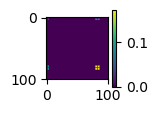

In [42]:
import matplotlib.pyplot as plt
where_opt_total_inds = np.asarray([
        ind in opt_total_inds for ind in np.arange(len(rank_one_vector))
    ],
    float)
sparsify_mat = where_opt_total_inds[:, None] * where_opt_total_inds[None, :]
sparsify_mat /= np.sqrt((sparsify_mat * (rank_one_vector @ rank_one_vector.T)).sum())
plt.figure(figsize=(1,1))
plt.imshow(sparsify_mat)
plt.colorbar()

In [36]:
(np.diagonal(sparsify_mat) * rank_one_vector ** 2).sum()

1.0

In [27]:
# (z * v)^T (z * v) = sum((v * z) .^ 2)
np.linalg.norm(rank_one_vector[opt_total_inds]) ** 2

5.267480676016405

In [30]:
# Tr (z z^T) (v v^T) = v^T (z z^T) v = (sum(v * z))^2
((where_opt_total_inds[:, None] * where_opt_total_inds[None, :])
    * (rank_one_vector @ rank_one_vector.T)).sum()

33.92699070404836

In [43]:
# matrix-vector multiplication
np.linalg.norm(
    (sparsify_mat * (residual_data.T @ residual_data)) @ rank_one_vector)

0.21282410087826933

In [37]:
# Squared matrix (still not linearized)
np.sqrt(
    (((sparsify_mat * (residual_data.T @ residual_data))
            @ (sparsify_mat * (residual_data.T @ residual_data)))
        * (rank_one_vector @ rank_one_vector.T)).sum())

0.008842287248010021

In [25]:
np.sqrt(
    (sparsify_mat * (rank_one_vector @ rank_one_vector.T)
        * (residual_data.T @ residual_data)).sum()
        * np.abs(residual_data.T @ residual_data).max())

0.2356956173576769